<a href="https://colab.research.google.com/github/shivam110601/abide_cnn_btech/blob/main/no_tx_resnet_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

Applying **Data Augmentation** on the dataset

In [6]:
# Part 1 - Getting the data and defining parameters

from keras.preprocessing.image import ImageDataGenerator
input_size = (64, 64)

train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/abide1datset/train',
                                                 target_size = input_size,
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale'
                                                 )

# test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/abide1datset/test',
                                            target_size = input_size,
                                            class_mode = 'binary',
                                            color_mode = 'grayscale')

Found 8636 images belonging to 2 classes.
Found 2460 images belonging to 2 classes.


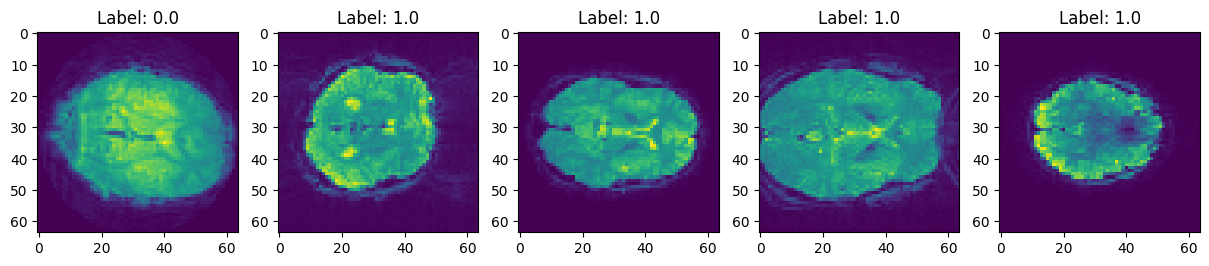

In [7]:
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    # Get a batch of augmented images
    batch = training_set.next()

    # Extract the first image and label from the batch
    image = batch[0][0]
    label = batch[1][0]



    # Display the image and label
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')

plt.show()

In [ ]:
image_names = training_set.filenames
labels = training_set.labels

for i in range(len(image_names)):
    print(f"Image Name: {image_names[i]}, Label: {labels[i]}")

# Image Name: ASD/slice0050815_025.png, Label: 0
# Image Name: TC/slice0050040_015.png, Label: 1

# **Training**

In [9]:
input_size += (1, )

resnet = ResNet50(weights=None,include_top=False,input_shape=input_size)

In [10]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 1)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
base_learning_rate = 0.001
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics= ['accuracy'])

In [15]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/abide1datset/notx_resnet50",monitor="accuracy",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

# Training The Model

In [16]:
initial_epochs = 10

history = model.fit(
    training_set,
    epochs=initial_epochs, verbose=1, batch_size=32,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/10
270/270 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5347
Epoch 1: accuracy improved from -inf to 0.53474, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 1250s 5s/step - loss: 0.6859 - accuracy: 0.5347 - lr: 0.0010
Epoch 2/10
270/270 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.5929
Epoch 2: accuracy improved from 0.53474 to 0.59287, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 48s 177ms/step - loss: 0.6664 - accuracy: 0.5929 - lr: 0.0010
Epoch 3/10
270/270 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.5948
Epoch 3: accuracy improved from 0.59287 to 0.59484, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 47s 176ms/step - loss: 0.6559 - accuracy: 0.5948 - lr: 0.0010
Epoch 4/10
270/270 [===========================

In [19]:
total_epochs = 25

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         verbose=1, batch_size=32,
                         callbacks=[checkpoint, reduce_lr])

Epoch 10/25
270/270 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.6824
Epoch 10: accuracy improved from 0.66848 to 0.68238, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 63s 233ms/step - loss: 0.5898 - accuracy: 0.6824 - lr: 0.0010
Epoch 11/25
270/270 [==============================] - ETA: 0s - loss: 0.5689 - accuracy: 0.7023
Epoch 11: accuracy improved from 0.68238 to 0.70229, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 50s 187ms/step - loss: 0.5689 - accuracy: 0.7023 - lr: 0.0010
Epoch 12/25
270/270 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7095
Epoch 12: accuracy improved from 0.70229 to 0.70947, saving model to /content/drive/MyDrive/abide1datset/notx_resnet50
270/270 [==============================] - 53s 198ms/step - loss: 0.5563 - accuracy: 0.7095 - lr: 0.0010
Epoch 13/25
270/270 [================

In [22]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/abide1datset/notx_resnet50",monitor="loss",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

In [ ]:
extended_epochs = 35

history_extended = model.fit(training_set,
                         epochs=extended_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         verbose=1, batch_size=32,
                         callbacks=[checkpoint, reduce_lr])

In [36]:
checkpoint = ModelCheckpoint("/content/drive/MyDrive/abide1datset/notx_resnet50",monitor="loss",save_best_only=True,verbose=1)
early_stopping = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=4)

In [ ]:
last_epochs = 60

history_last = model.fit(training_set,
                         epochs=last_epochs,
                         initial_epoch=history_extended.epoch[-1],
                         verbose=1, batch_size=32,
                         callbacks=[checkpoint, early_stopping])

Loss and Accuracy

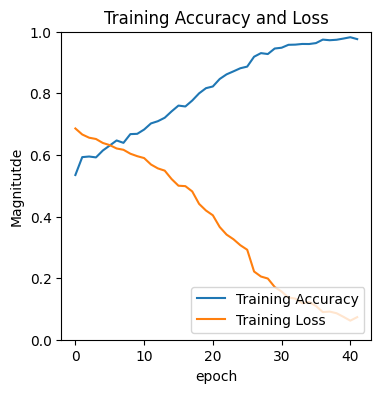

In [39]:
acc = history.history['accuracy'] + history_fine.history['accuracy'] + history_extended.history['accuracy'] + [0.9724, 0.9739, 0.9778, 0.9821, 0.9760]
loss = history.history['loss'] + history_fine.history['loss'] + history_extended.history['loss'] + [0.0913, 0.0860, 0.0743, 0.0619, 0.0733]

plt.figure(figsize=(4, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(loss, label='Training Loss')
plt.legend(loc='lower right')
plt.ylabel('Magnitutde')
plt.ylim([0,1.0])
plt.title('Training Accuracy and Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation

In [40]:
model.load_weights("/content/drive/MyDrive/abide1datset/notx_resnet50")

In [41]:
# Evaluate the performance of the model
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

# 42/76 [===============>..............] - ETA: 6:19 - loss: 0.8339 - accuracy: 0.4412

76/76 [==============================] - 516s 7s/step - loss: 2.5042 - accuracy: 0.4597
Accuracy Test : 0.4597039520740509


In [42]:
from sklearn.metrics import accuracy_score, roc_curve, auc

77/77 [==============================] - 6s 64ms/step
Test Accuracy: 50.45%


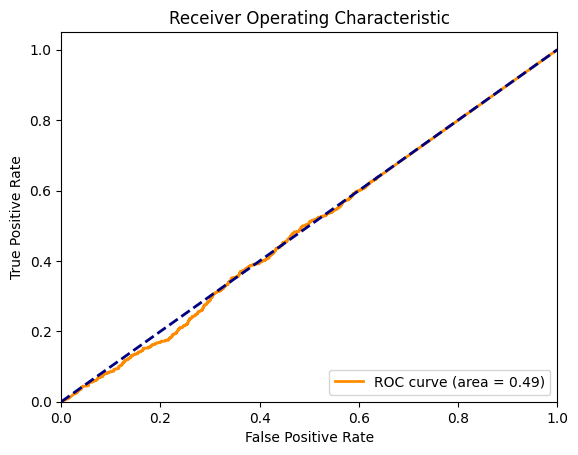

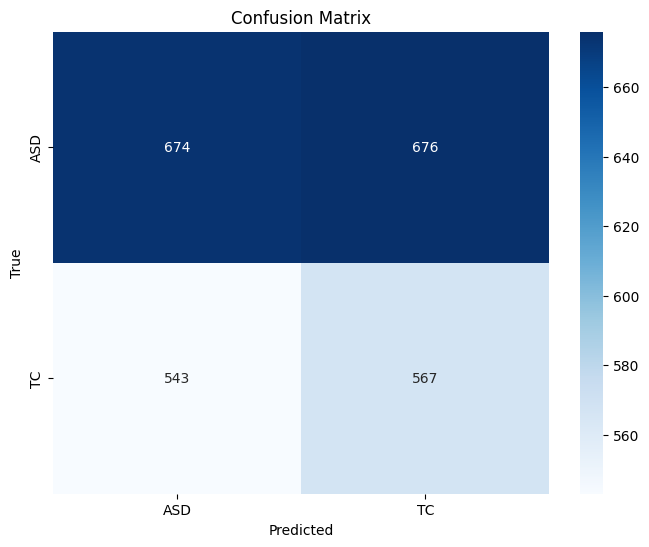

Confusion Matrix:
[[674 676]
 [543 567]]


In [43]:
class_names = list(training_set.class_indices.keys())

# Make predictions on the test data
predictions = model.predict(test_set)

# 'predictions' will contain the predicted probabilities for each image
# For binary classification, you can threshold the probabilities to get class predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get the true class labels for the test data
true_classes = test_set.classes

# Calculate test accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Print and return the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print and return the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)